#### 8. UMAP 분석

In [38]:
# 참고: https://www.kaggle.com/code/danielkorth/visualizing-neural-networks-using-t-sne-and-umap/notebook

import os
import multiprocessing

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
# import torchvision
# import pandas as pd
import matplotlib.pyplot as plt

from importlib import import_module

# import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [ ]:
import timm

In [39]:
use_cuda = torch.cuda.is_available()
# GPU 사용가능하면 True 반환

device = torch.device("cuda" if use_cuda else "cpu")
print(f"==>> device: {device}")

==>> device: cuda


In [40]:
backbone1 = timm.create_model("resnet50", pretrained=True, num_classes=0)
x = torch.randn(1,3,224,224)
y = backbone1(x)
print(f"==>> y.shape: {y.shape}")

model.safetensors: 100%|██████████| 102M/102M [00:00<00:00, 378MB/s] 


==>> y.shape: torch.Size([1, 2048])


In [41]:
timm.list_models('efficient*', pretrained=True)

['efficientformer_l1.snap_dist_in1k',
 'efficientformer_l3.snap_dist_in1k',
 'efficientformer_l7.snap_dist_in1k',
 'efficientformerv2_l.snap_dist_in1k',
 'efficientformerv2_s0.snap_dist_in1k',
 'efficientformerv2_s1.snap_dist_in1k',
 'efficientformerv2_s2.snap_dist_in1k',
 'efficientnet_b0.ra_in1k',
 'efficientnet_b1.ft_in1k',
 'efficientnet_b1_pruned.in1k',
 'efficientnet_b2.ra_in1k',
 'efficientnet_b2_pruned.in1k',
 'efficientnet_b3.ra2_in1k',
 'efficientnet_b3_pruned.in1k',
 'efficientnet_b4.ra2_in1k',
 'efficientnet_b5.sw_in12k',
 'efficientnet_b5.sw_in12k_ft_in1k',
 'efficientnet_el.ra_in1k',
 'efficientnet_el_pruned.in1k',
 'efficientnet_em.ra2_in1k',
 'efficientnet_es.ra_in1k',
 'efficientnet_es_pruned.in1k',
 'efficientnet_lite0.ra_in1k',
 'efficientnetv2_rw_m.agc_in1k',
 'efficientnetv2_rw_s.ra2_in1k',
 'efficientnetv2_rw_t.ra2_in1k',
 'efficientvit_b0.r224_in1k',
 'efficientvit_b1.r224_in1k',
 'efficientvit_b1.r256_in1k',
 'efficientvit_b1.r288_in1k',
 'efficientvit_b2.r224_i

In [ ]:
backbone2 = timm.create_model("resnet50", pretrained=True, num_classes=0)
x = torch.randn(1, 3, 224, 224)
y = backbone1(x)
print(f"==>> y.shape: {y.shape}")

In [30]:
def load_model(saved_model, model_name, num_classes, device):
    """
    저장된 모델의 가중치를 로드하는 함수입니다.

    Args:
        saved_model (str): 모델 가중치가 저장된 디렉토리 경로
        num_classes (int): 모델의 클래수 수
        device (torch.device): 모델이 로드될 장치 (CPU 또는 CUDA)

    Returns:
        model (nn.Module): 가중치가 로드된 모델
    """
    model_cls = getattr(import_module("model"), model_name)
    model = model_cls(num_classes=num_classes)
    # tarpath = os.path.join(saved_model, 'best.tar.gz')
    # tar = tarfile.open(tarpath, 'r:gz')
    # tar.extractall(path=saved_model)

    # 모델 가중치를 로드한다.
    model_path = os.path.join(saved_model, "best.pth")
    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    # model.load_state_dict(torch.load(model_path, map_location=device))
    # %% torch.save에서 optimizer, scheduler 같이 저장 안한 경우
    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    return model

In [47]:
model_dir = "/data/ephemeral/home/level1-imageclassification-cv-12/model/202312191300/bkh_202312191300"
# 불러올 모델 경로 (best.pth가 들어있는 폴더)
data_dir = "/data/ephemeral/home/train/images"
# 사진 경로
model_name = "MFEfficientResNet"
# 모델 클래스 이름
dataset_name = "MaskSplitByProfileDataset"
# 사용할 데이터셋 클래스 이름
aug_name = "CustomAugmentation"
# 사용할 aug 클래스 이름
resize = [196,144]
# 모델 훈련에 사용한 resize 값과 동일하게 설정
num_classes = 18

In [48]:
model = load_model(model_dir, model_name, num_classes, device).to(device)
# model 불러오기

dataset_module = getattr(import_module("dataset"), dataset_name)  # default: MaskBaseDataset
dataset = dataset_module(
    data_dir=data_dir,
)

transform_module = getattr(import_module("dataset"), aug_name)  # default: BaseAugmentation
transform = transform_module(
    resize=resize,
    mean=dataset.mean,
    std=dataset.std,
)
dataset.set_transform(transform)
# dataset, aug 불러오기


loader = DataLoader(
    dataset,
    batch_size=1000,
    num_workers=multiprocessing.cpu_count() // 2,
    shuffle=False,
    pin_memory=use_cuda,
    drop_last=True,
)
# dataloader 설정

/opt/conda/envs/cv12_bkh/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/cv12_bkh/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/envs/cv12_bkh/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.

: 

In [35]:
def embedding(data):
    """
    시각화 하려는 feature vector 생성 함수
    시각화할 layer output을 여기서 계산 

    Args:
        data (torch.Tensor): 사진 인풋

    Returns:
        torch.Tensor: feature vector 
    """
    model.eval()
    x1 = model.backbone1(data)
    x2 = model.backbone2(data)
    x1 = x1.view(data.size(0), -1)
    x2 = x2.view(data.size(0), -1)

    x_mask = model.mask_classifier[:-1](x1)
    x_gender = model.gender_classifier[:-1](x2)
    x_age = model.age_classifier[:-1](x2)
    # ex: 각 classifier의 마지막 fc layer 바로 전 layer output을 확인 중
    return x_mask, x_gender, x_age

In [36]:
data, label = next(iter(loader))
# batch_size = 1000 개 랜덤 추출

data = data.to(device)
print(f"==>> data.shape: {data.shape}")
label = label.to(device)
print(f"==>> label.shape: {label.shape}")

mask_label, gender_label, age_label = dataset.decode_multi_class(label)

with torch.no_grad():  # 없으면 1000개 grad_fn 저장하느라 메모리 부족
    embedding_mask, embedding_gender, embedding_age = embedding(data)

==>> data.shape: torch.Size([1000, 3, 196, 144])
==>> label.shape: torch.Size([1000])


/data/ephemeral/home/level1-imageclassification-cv-12/dataset.py:356: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  mask_label = (multi_class_label // 6) % 3
/data/ephemeral/home/level1-imageclassification-cv-12/dataset.py:357: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  gender_label = (multi_class_label // 3) % 2


In [37]:
from umap.umap_ import UMAP
# pip install umap-learn 설치 필요

umap_hparams = {"n_neighbors": 15, "min_dist": 0.25, "n_components": 2, "metric": "euclidean"}
# umap_hparams = {"n_neighbors": 5, "min_dist": 0.1, "n_components": 2, "metric": "euclidean"}

In [38]:
plt.style.use('default')

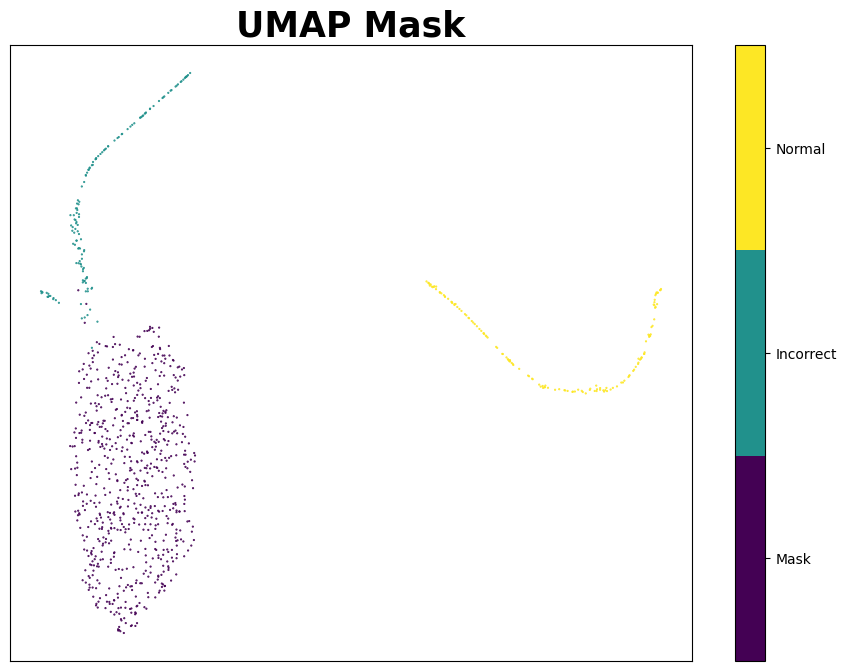

In [39]:
fig, ax = plt.subplots(figsize=(11, 8), constrained_layout=False)
ax.set(xticks=[], yticks=[])

umap_embedding_mask = UMAP(
    n_neighbors=umap_hparams["n_neighbors"],
    min_dist=umap_hparams["min_dist"],
    n_components=umap_hparams["n_components"],
    metric=umap_hparams["metric"],
).fit_transform(embedding_mask.detach().cpu().numpy())
scatter = ax.scatter(
    x=umap_embedding_mask[:, 0], y=umap_embedding_mask[:, 1], s=0.3, c=mask_label.cpu(),
)

cbar = plt.colorbar(scatter, boundaries=np.arange(4) - 0.5)
cbar.set_ticks(np.arange(3))
cbar.set_ticklabels(["Mask", "Incorrect", "Normal"])

plt.title("UMAP Mask", fontsize=25, fontweight="bold")
plt.show()

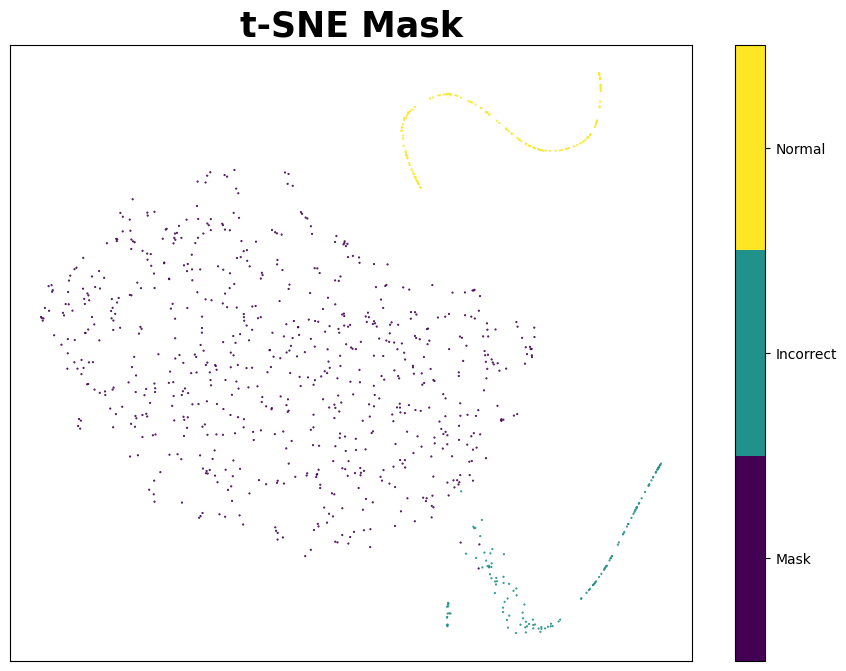

In [40]:
# embedding_mask는 PyTorch Tensor이므로 numpy로 변환합니다.
embedding_mask_np = embedding_mask.detach().cpu().numpy()

# t-SNE를 계산합니다.
tsne_embedding_mask = TSNE(n_components=2, perplexity=30, n_iter=300).fit_transform(embedding_mask_np)

# 시각화를 위한 코드입니다.
fig, ax = plt.subplots(figsize=(11, 8), constrained_layout=False)
ax.set(xticks=[], yticks=[])

scatter = ax.scatter(
    x=tsne_embedding_mask[:, 0], y=tsne_embedding_mask[:, 1], s=0.3, c=mask_label.cpu(),
)

cbar = plt.colorbar(scatter, boundaries=np.arange(4) - 0.5)
cbar.set_ticks(np.arange(3))
cbar.set_ticklabels(["Mask", "Incorrect", "Normal"])

plt.title("t-SNE Mask", fontsize=25, fontweight="bold")
plt.show()


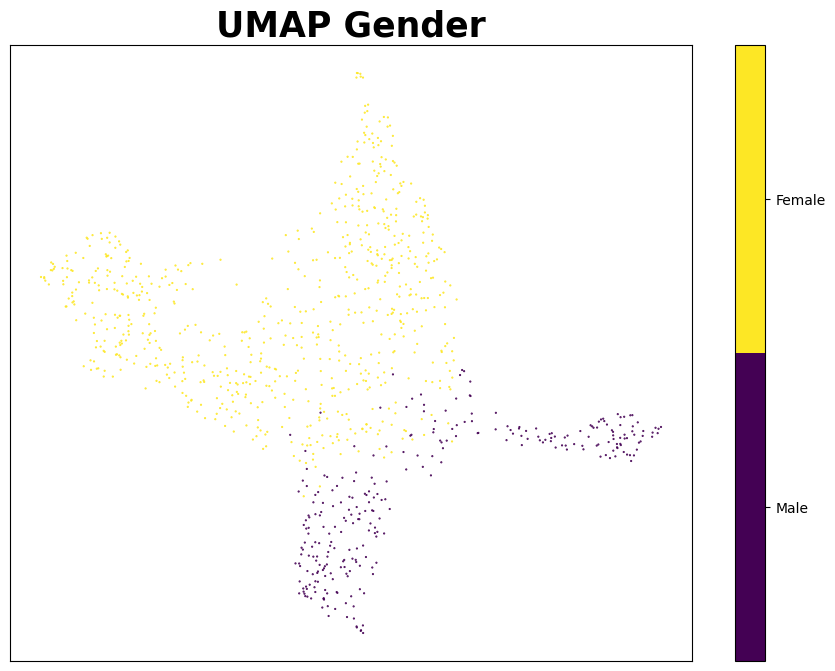

In [41]:
fig, ax = plt.subplots(figsize=(11, 8), constrained_layout=False)
ax.set(xticks=[], yticks=[])

umap_embedding_gender = UMAP(
    n_neighbors=umap_hparams["n_neighbors"],
    min_dist=umap_hparams["min_dist"],
    n_components=umap_hparams["n_components"],
    metric=umap_hparams["metric"],
).fit_transform(embedding_gender.detach().cpu().numpy())
scatter = ax.scatter(
    x=umap_embedding_gender[:, 0], y=umap_embedding_gender[:, 1], s=0.3, c=gender_label.cpu(),
)

cbar = plt.colorbar(scatter, boundaries=np.arange(3) - 0.5)
cbar.set_ticks(np.arange(2))
cbar.set_ticklabels(["Male", "Female"])

plt.title("UMAP Gender", fontsize=25, fontweight="bold")
plt.show()

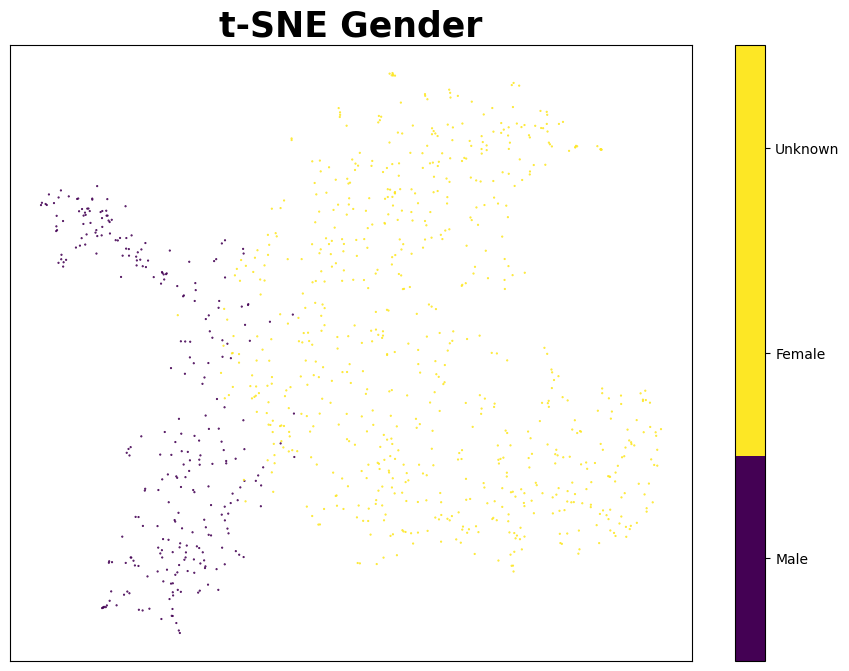

In [42]:
# embedding_gender는 PyTorch Tensor이므로 numpy로 변환합니다.
embedding_gender_np = embedding_gender.detach().cpu().numpy()

# t-SNE를 계산합니다.
tsne_embedding_gender = TSNE(n_components=2, perplexity=30, n_iter=300).fit_transform(embedding_gender_np)

# 시각화를 위한 코드입니다.
fig, ax = plt.subplots(figsize=(11, 8), constrained_layout=False)
ax.set(xticks=[], yticks=[])

scatter = ax.scatter(
    x=tsne_embedding_gender[:, 0], y=tsne_embedding_gender[:, 1], s=0.3, c=gender_label.cpu(),
)

cbar = plt.colorbar(scatter, boundaries=np.arange(4) - 0.5)
cbar.set_ticks(np.arange(3))
cbar.set_ticklabels(["Male", "Female", "Unknown"])

plt.title("t-SNE Gender", fontsize=25, fontweight="bold")
plt.show()

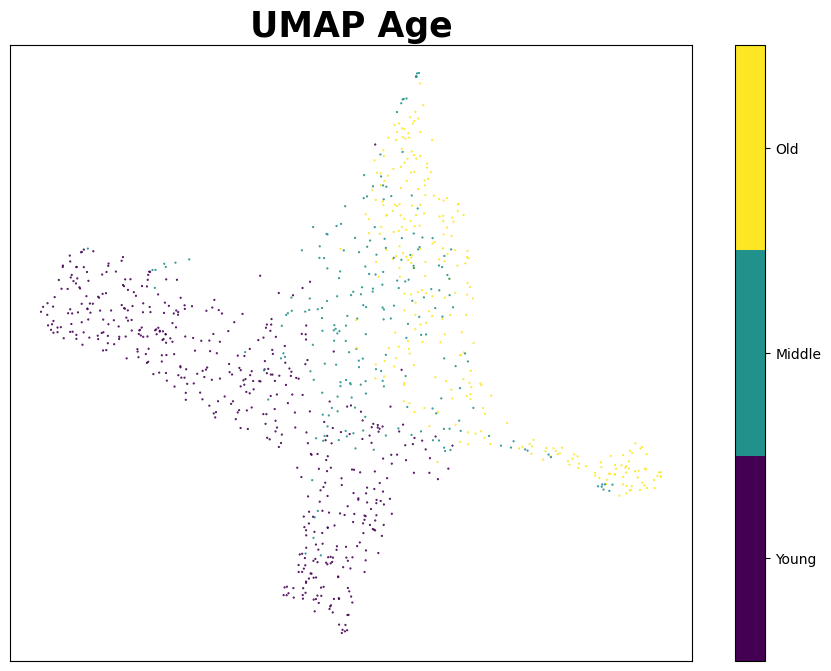

In [43]:
fig, ax = plt.subplots(figsize=(11, 8), constrained_layout=False)
ax.set(xticks=[], yticks=[])

umap_embedding_age = UMAP(
    n_neighbors=umap_hparams["n_neighbors"],
    min_dist=umap_hparams["min_dist"],
    n_components=umap_hparams["n_components"],
    metric=umap_hparams["metric"],
).fit_transform(embedding_gender.detach().cpu().numpy())
scatter = ax.scatter(
    x=umap_embedding_age[:, 0], y=umap_embedding_age[:, 1], s=0.3, c=age_label.cpu(),
)

cbar = plt.colorbar(scatter, boundaries=np.arange(4) - 0.5)
cbar.set_ticks(np.arange(3))
cbar.set_ticklabels(["Young", "Middle", "Old"])

plt.title("UMAP Age", fontsize=25, fontweight="bold")
plt.show()

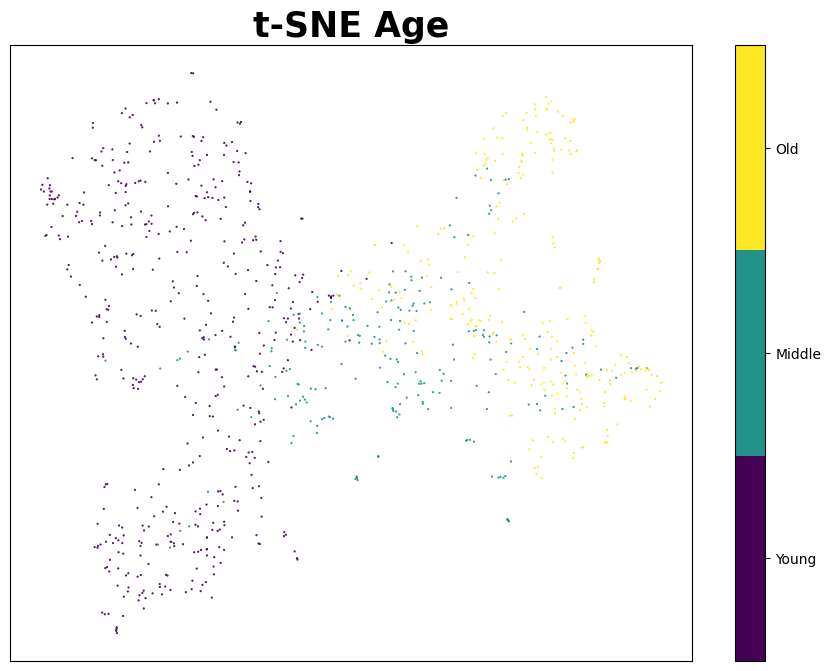

In [44]:
# embedding_age는 PyTorch Tensor이므로 numpy로 변환합니다.
embedding_age_np = embedding_age.detach().cpu().numpy()

# t-SNE를 계산합니다.
tsne_embedding_age = TSNE(n_components=2, perplexity=30, n_iter=300).fit_transform(embedding_age_np)

# 시각화를 위한 코드입니다.
fig, ax = plt.subplots(figsize=(11, 8), constrained_layout=False)
ax.set(xticks=[], yticks=[])

scatter = ax.scatter(
    x=tsne_embedding_age[:, 0], y=tsne_embedding_age[:, 1], s=0.3, c=age_label.cpu(),
)

cbar = plt.colorbar(scatter, boundaries=np.arange(4) - 0.5)
cbar.set_ticks(np.arange(3))
cbar.set_ticklabels(["Young", "Middle", "Old"])

plt.title("t-SNE Age", fontsize=25, fontweight="bold")
plt.show()

### LEVEL1 IMAGE CLASSIFICATION EDA

#### 0. 필요 라이브러리 불러오기

In [1]:
import os
import sys
from glob import glob
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from tqdm.notebook import tqdm
from time import time

import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import multiprocessing as mp

plt.style.use('default')

#### 1. 데이터 불러오기

In [2]:
class cfg:
    data_dir = '/data/ephemeral/home/train'  
    img_dir = '/data/ephemeral/home/removed_background'
    df_path = f'{data_dir}/train.csv'

In [3]:
num2class = ['incorrect_mask', 'mask1', 'mask2', 'mask3',
             'mask4', 'mask5', 'normal']
class2num = {k: v for v, k in enumerate(num2class)}

df = pd.read_csv(cfg.df_path)
df.head()

id  gender   race  age                    path
0  000001  female  Asian   45  000001_female_Asian_45
1  000002  female  Asian   52  000002_female_Asian_52
2  000004    male  Asian   54    000004_male_Asian_54
3  000005  female  Asian   58  000005_female_Asian_58
4  000006  female  Asian   59  000006_female_Asian_59

In [4]:
class2num

{'incorrect_mask': 0,
 'mask1': 1,
 'mask2': 2,
 'mask3': 3,
 'mask4': 4,
 'mask5': 5,
 'normal': 6}

#### 2. 이미지 기본정보 확인

In [5]:
def get_ext(img_dir, img_id):
    """
    학습 데이터셋 이미지 폴더에는 여러 하위폴더로 구성되고, 이 하위폴더들에는 각 사람의 사진들이 들어가있습니다. 하위폴더에 속한 이미지의 확장자를 구하는 함수입니다.
    
    Args:
        img_dir: 학습 데이터셋 이미지 폴더 경로 
        img_id: 학습 데이터셋 하위폴더 이름

    Returns:
        ext: 이미지의 확장자
    """
    filename = os.listdir(os.path.join(img_dir, img_id))
    ext = [os.path.splitext(file)[-1].lower() for file in filename]
    return ext

In [6]:
def get_img_stats(img_dir, img_ids):
    """
    데이터셋에 있는 이미지들의 크기와 RGB 평균 및 표준편차를 수집하는 함수입니다.
    
    Args:
        img_dir: 학습 데이터셋 이미지 폴더 경로 
        img_ids: 학습 데이터셋 하위폴더 이름들

    Returns:
        img_info: 이미지들의 정보 (크기, 평균, 표준편차)
    """
    img_info = dict(heights=[], widths=[], means=[], stds=[])
    for img_id in tqdm(img_ids):
        for path in glob(os.path.join(img_dir, img_id, '*')):
            img = np.array(Image.open(path))
            h, w, _ = img.shape
            img_info['heights'].append(h)
            img_info['widths'].append(w)
            img_info['means'].append(img.mean(axis=(0,1)))
            img_info['stds'].append(img.std(axis=(0,1)))
    return img_info

In [47]:
# original train data

img_info = get_img_stats(cfg.img_dir, df.path.values[:100])

print(f'Total number of people is {len(df)}')
print(f'Total number of images is {len(df) * 7}')

print(f'Minimum height for dataset is {np.min(img_info["heights"])}')
print(f'Maximum height for dataset is {np.max(img_info["heights"])}')
print(f'Average height for dataset is {int(np.mean(img_info["heights"]))}')
print(f'Minimum width for dataset is {np.min(img_info["widths"])}')
print(f'Maximum width for dataset is {np.max(img_info["widths"])}')
print(f'Average width for dataset is {int(np.mean(img_info["widths"]))}')

print(f'RGB Mean: {np.mean(img_info["means"], axis=0) / 255.}')
print(f'RGB Standard Deviation: {np.mean(img_info["stds"], axis=0) / 255.}')

  0%|          | 0/100 [00:00<?, ?it/s]

Total number of people is 2700
Total number of images is 18900
Minimum height for dataset is 512
Maximum height for dataset is 512
Average height for dataset is 512
Minimum width for dataset is 384
Maximum width for dataset is 384
Average width for dataset is 384
RGB Mean: [0.55800916 0.51224077 0.47767341]
RGB Standard Deviation: [0.21817792 0.23804603 0.25183411]


In [7]:
# removed_background train data

img_info = get_img_stats(cfg.img_dir, df.path.values[:100])

print(f'Total number of people is {len(df)}')
print(f'Total number of images is {len(df) * 7}')

print(f'Minimum height for dataset is {np.min(img_info["heights"])}')
print(f'Maximum height for dataset is {np.max(img_info["heights"])}')
print(f'Average height for dataset is {int(np.mean(img_info["heights"]))}')
print(f'Minimum width for dataset is {np.min(img_info["widths"])}')
print(f'Maximum width for dataset is {np.max(img_info["widths"])}')
print(f'Average width for dataset is {int(np.mean(img_info["widths"]))}')

print(f'RGB Mean: {np.mean(img_info["means"], axis=0) / 255.}')
print(f'RGB Standard Deviation: {np.mean(img_info["stds"], axis=0) / 255.}')

  0%|          | 0/100 [00:00<?, ?it/s]

Total number of people is 2700
Total number of images is 18900
Minimum height for dataset is 512
Maximum height for dataset is 512
Average height for dataset is 512
Minimum width for dataset is 384
Maximum width for dataset is 384
Average width for dataset is 384
RGB Mean: [0.20003478 0.1720036  0.16412438 0.44201315]
RGB Standard Deviation: [0.26286363 0.23418451 0.22982625 0.48095304]


#### 3. target 분석

/tmp/ipykernel_896693/1046520837.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x = 'gender', data = df, palette=["#55967e", "#263959"])


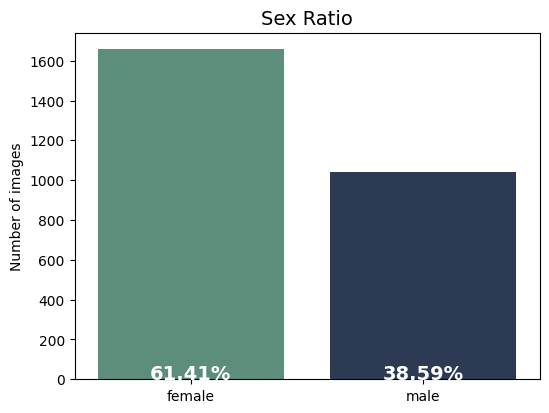

In [62]:
plt.figure(figsize=(6, 4.5)) 
ax = sns.countplot(x = 'gender', data = df, palette=["#55967e", "#263959"])

plt.xticks( np.arange(2), ['female', 'male'] )
plt.title('Sex Ratio',fontsize= 14)
plt.xlabel('')
plt.ylabel('Number of images')

counts = df['gender'].value_counts()
counts_pct = [f'{elem * 100:.2f}%' for elem in counts / counts.sum()]
for i, v in enumerate(counts_pct):
    ax.text(i, 0, v, horizontalalignment = 'center', size = 14, color = 'w', fontweight = 'bold')
    
plt.show()

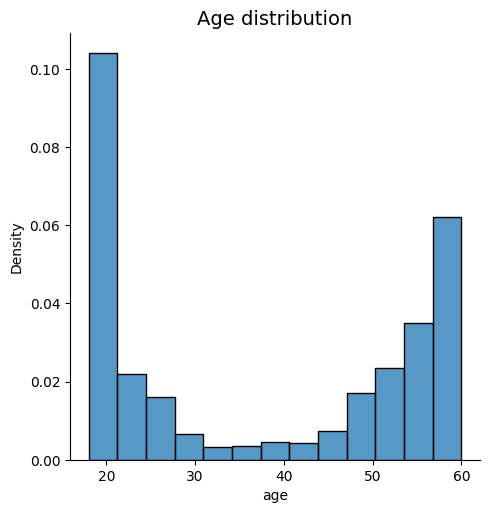

In [63]:
sns.displot(df, x="age", stat="density")
plt.title('Age distribution',fontsize= 14)
plt.show()

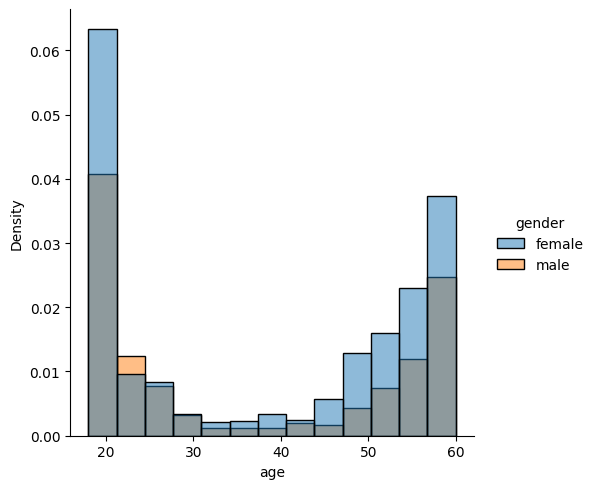

In [64]:
sns.displot(df, x="age", hue="gender", stat="density")
plt.show()

In [52]:
df['age'].describe()

count    2700.000000
mean       37.708148
std        16.985904
min        18.000000
25%        20.000000
50%        36.000000
75%        55.000000
max        60.000000
Name: age, dtype: float64

In [59]:
df[df['gender']=='male']['age'].describe()

count    1042.000000
mean       36.403071
std        17.066934
min        18.000000
25%        20.000000
50%        26.000000
75%        56.000000
max        60.000000
Name: age, dtype: float64

In [60]:
df[df['gender']=='female']['age'].describe()

count    1658.000000
mean       38.528347
std        16.888379
min        18.000000
25%        20.000000
50%        44.000000
75%        55.000000
max        60.000000
Name: age, dtype: float64

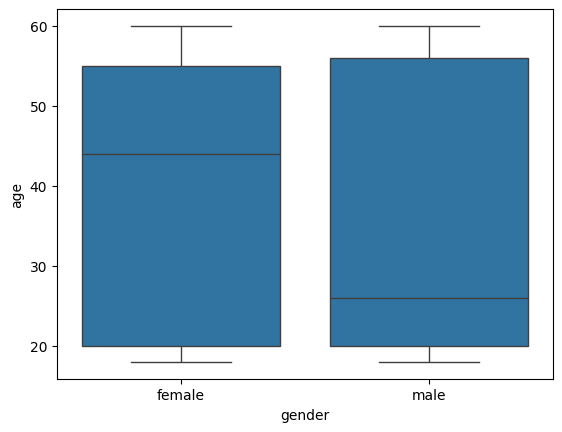

In [65]:
sns.boxplot(x='gender', y='age', data=df)
plt.show()

#### 4. X, y 관계 분석

##### 4-1. RGB 값과 target class 간의 관계

In [67]:
img_id = df.iloc[500].path
ext = get_ext(cfg.img_dir, img_id)

In [77]:
sns.set_palette('bright')

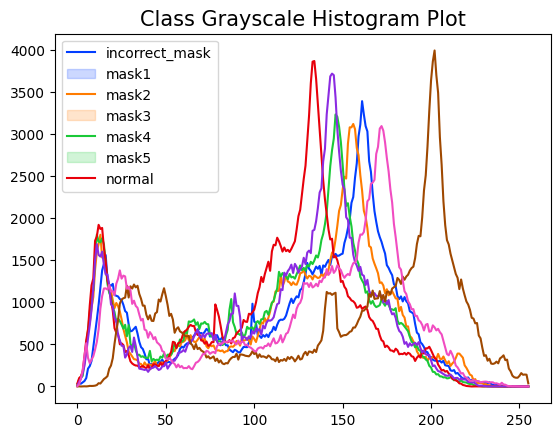

In [78]:
plt.figure()
plt.subplot(111)

for class_id in num2class:
    img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, class_id+ext)).convert('L'))
    histogram, bin_edges = np.histogram(img, bins=256, range=(0, 255))
    sns.lineplot(data=histogram)

plt.legend(num2class)
plt.title('Class Grayscale Histogram Plot', fontsize=15)
plt.show()

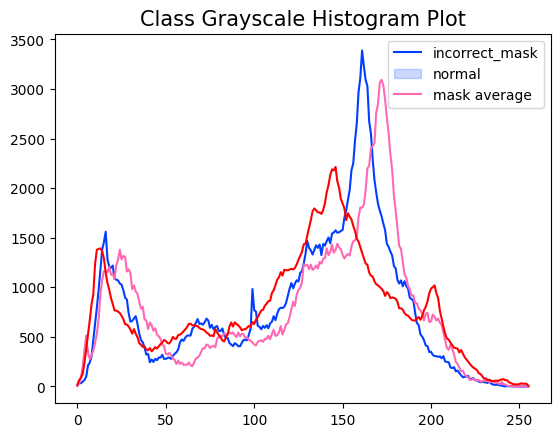

In [80]:
plt.figure()
plt.subplot(111)

img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, 'incorrect_mask'+ext)).convert('L'))
histogram, bin_edges = np.histogram(img, bins=256, range=(0, 255))
sns.lineplot(data=histogram)

img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, 'normal'+ext)).convert('L'))
histogram, bin_edges = np.histogram(img, bins=256, range=(0, 255))
sns.lineplot(data=histogram, color='hotpink')

histograms = []
for i in range(1, 6):
    img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, num2class[i]+ext)).convert('L'))
    histogram, bin_edges = np.histogram(img, bins=256, range=(0, 255))
    histograms.append(histogram)
sns.lineplot(data=np.mean(histograms, axis=0), color='red')

plt.legend(['incorrect_mask', 'normal', 'mask average'])
plt.title('Class Grayscale Histogram Plot', fontsize=15)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


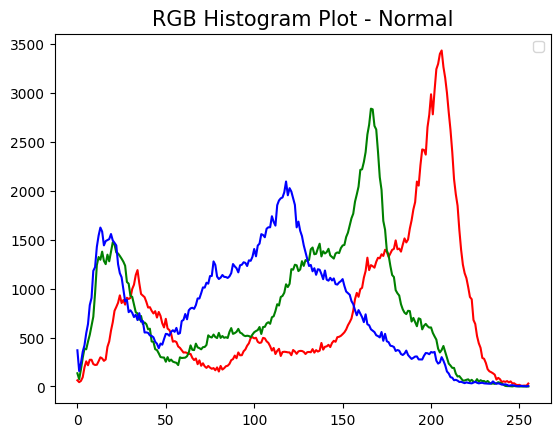

In [81]:
plt.figure()
plt.subplot(111)

img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, 'normal'+ext)))
colormap = ['red', 'green', 'blue']
for i in range(3):
    histogram, bin_edges = np.histogram(img[..., i], bins=256, range=(0, 255))
    sns.lineplot(data=histogram, color=colormap[i])

plt.legend()
plt.title('RGB Histogram Plot - Normal', fontsize=15)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


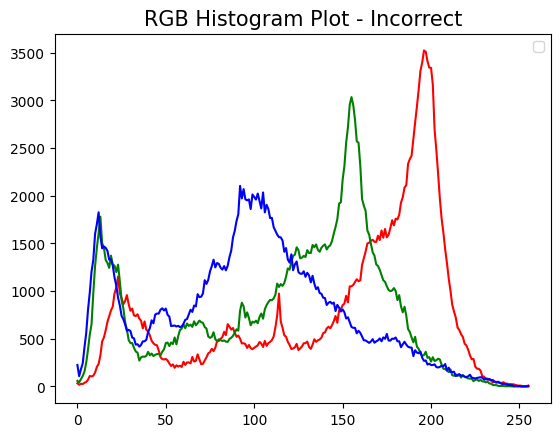

In [83]:
plt.figure()
plt.subplot(111)

img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, 'incorrect_mask'+ext)))
colormap = ['red', 'green', 'blue']
for i in range(3):
    histogram, bin_edges = np.histogram(img[..., i], bins=256, range=(0, 255))
    sns.lineplot(data=histogram, color=colormap[i])

plt.legend()
plt.title('RGB Histogram Plot - Incorrect', fontsize=15)
plt.show()

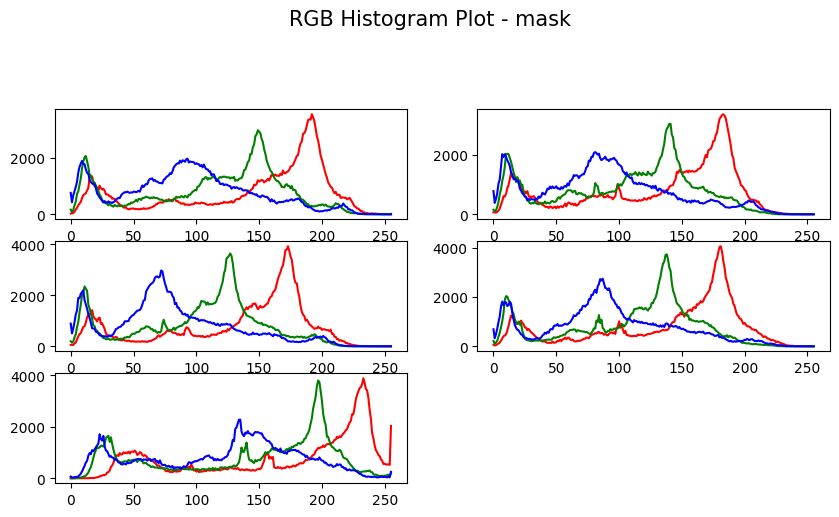

In [123]:
plt.figure(figsize=(10,10))
plt.suptitle('RGB Histogram Plot - mask', fontsize=15)
for j in range(1, 6):
    img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, f'mask{j}'+ext)))
    colormap = ['red', 'green', 'blue']
    f = 620 + j
    plt.subplot(f)
    for i in range(3):
        histogram, bin_edges = np.histogram(img[..., i], bins=256, range=(0, 255))
        sns.lineplot(data=histogram, color=colormap[i])

plt.show()

##### 4-2. ID 별 이미지 확인

In [124]:
def plot_mask_images(img_dir, img_id):
    """
    마스크 정상착용 5장과 이상하게 착용한 1장을 2x3의 격자에 시각화하는 함수입니다.
    
    Args:
        img_dir: 학습 데이터셋 이미지 폴더 경로 
        img_id: 학습 데이터셋 하위폴더 이름
    """
    ext = get_ext(img_dir, img_id)
    imgs = [np.array(Image.open(os.path.join(img_dir, img_id, class_name + ext))) for class_name in num2class[:-1]]
    
    n_rows, n_cols = 2, 3
    fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(10, 8))
    for i in range(n_rows*n_cols):
        axes[i//(n_rows+1)][i%n_cols].imshow(imgs[i])
        axes[i//(n_rows+1)][i%n_cols].set_title(f'{num2class[i]}', color='r')
    plt.tight_layout()
    plt.show()

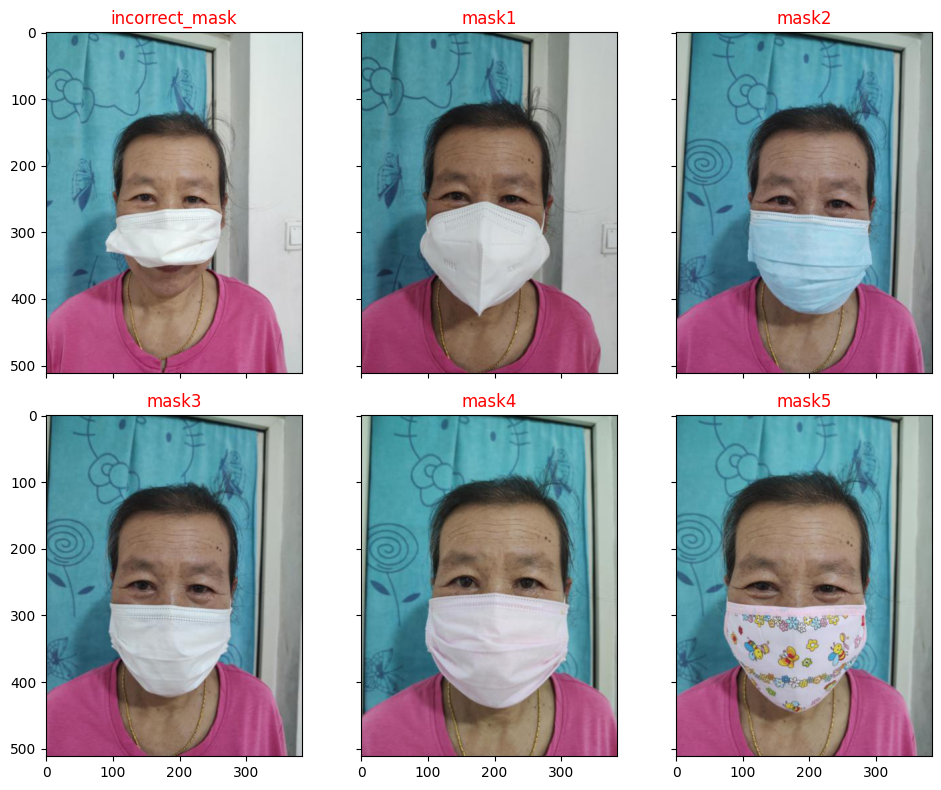

In [125]:
idx = 277
img_id = df.iloc[idx].path
plot_mask_images(cfg.img_dir, img_id)

##### 4-3. Age 불균형 확인

In [33]:
from dataset import MaskBaseDataset

In [37]:
dataset = MaskBaseDataset('/data/ephemeral/home/train')
dataset.setup()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/conda/envs/cv12_bkh/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1033221/2041492408.py", line 1, in <module>
    dataset = MaskBaseDataset('/data/ephemeral/home/train')
  File "/data/ephemeral/home/level1-imageclassification-cv-12/dataset.py", line 224, in __init__
  File "/data/ephemeral/home/level1-imageclassification-cv-12/dataset.py", line 262, in setup
    continue
NotADirectoryError: [Errno 20] Not a directory: '/data/ephemeral/home/train/train.csv'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/envs/cv12_bkh/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2102, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/opt/conda/envs/cv12_bkh/lib/python3.8/site-packages/IPython/core/ultratb.py", line 13

AttributeError: 'BalancedDataset' object has no attribute 'labels'

#### 5. PCA, t-SNE

In [18]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [130]:
imgs = []
for img_id in tqdm(df.path.values):
    for class_id in num2class:
        
        img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, class_id+ext)).convert('L'))
        imgs.append(img)
imgs = np.array(imgs)
n_samples, h, w = imgs.shape

imgs = np.reshape(imgs, (n_samples, h*w))

  0%|          | 0/2700 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: '/data/ephemeral/home/train/images/006056_female_Asian_19/incorrect_mask.jpg'

In [134]:
os.listdir(os.path.join(cfg.img_dir, '006056_female_Asian_19'))

['mask3.png',
 'mask2.png',
 'incorrect_mask.png',
 'mask5.png',
 'mask1.png',
 'normal.png',
 'mask4.png']

In [147]:
count = 0
for path in os.listdir(cfg.img_dir):
    for k in os.listdir(os.path.join(cfg.img_dir, path)):
        if os.path.splitext(k)[-1] != '.jpg':
            count+=1
count

865

In [153]:
imgs = []
for img_id in tqdm(df.path.values):
    for class_id in num2class:
        exts = get_ext(cfg.img_dir, img_id)
        for ext in exts:
            if os.path.exists(os.path.join(cfg.img_dir, img_id, class_id+ext)):
                img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, class_id+ext)).convert('L'))
                break
            else:
                continue
        imgs.append(img)
imgs = np.array(imgs)
n_samples, h, w = imgs.shape

imgs = np.reshape(imgs, (n_samples, h*w))

  0%|          | 0/2700 [00:00<?, ?it/s]

In [154]:
n_components = 30

t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(imgs)
print(f"pca is fitted in {time() - t0:.0f}s")
print(f'Explained variation per principal component: \n{pca.explained_variance_ratio_}')

eigenfaces = pca.components_.reshape((n_components, h, w))
img_pca = pca.transform(imgs)

pca is fitted in 75s
Explained variation per principal component: 
[0.20816311 0.15613417 0.0575186  0.04670163 0.04321229 0.03293999
 0.02350756 0.020633   0.01580877 0.01498412 0.013736   0.0124779
 0.01029336 0.00978517 0.00845362 0.00800897 0.00744352 0.00624046
 0.00608152 0.00575837 0.005135   0.0048314  0.00460821 0.00428254
 0.00398157 0.00377711 0.00353579 0.00342119 0.0033229  0.00317481]


In [155]:
pca_df = pd.DataFrame(img_pca, columns=[str(col) for col in range(n_components)])
pca_df['class_id'] = [num2class[n % len(num2class)] for n in range(n_samples)]
pca_df['class_id'] = pca_df['class_id'].map(lambda x: x if x in ['incorrect_mask', 'normal'] else 'mask')

In [156]:
pca_df.head()

0         1         2         3         4         5         6  \
0 -0.442210  0.040759  0.383866 -0.664444  0.360405 -0.562080  0.397739   
1 -1.030080  0.232641  0.588784 -0.251184  1.319727 -1.069789 -1.311773   
2 -0.514567 -0.003683  0.582833 -0.568001  0.268380 -0.619997  0.383686   
3 -0.086060  0.233141  0.319040 -0.900443  0.456751 -0.451887  0.769828   
4 -0.245212  0.165721  0.311449 -0.828603  0.423365 -0.619090  0.448203   

          7         8         9  ...        21        22        23        24  \
0  0.308105 -0.907204 -0.177900  ... -0.116167 -0.402874 -0.123545  1.860765   
1  2.215526 -0.927524 -0.366575  ... -1.282609 -2.330006  0.592001 -0.242606   
2  0.237827 -0.972503 -0.214661  ... -0.472834 -0.375323 -0.157321  1.436620   
3  0.014173 -0.471065 -0.912410  ... -1.102708 -0.947534  0.281951  1.536281   
4 -0.041552 -0.879161 -0.380735  ... -0.481714 -0.656673  0.075031  1.949488   

         25        26        27        28        29        class_id  
0 -0.737759 -1.620405  0.561554  0.010506 -0.295250  incorrect_mask  
1  0.194903  0.511135  0.196159  0.181313 -1.708293            mask  
2 -0.979002 -1.842980 -0.303016  0.555708 -0.218032            mask  
3 -0.697230 -0.253731  1.040116  0.931130  0.372976            mask  
4 -0.970273 -1.163376  0.880759  0.090724 -0.325599            mask  

[5 rows x 31 columns]

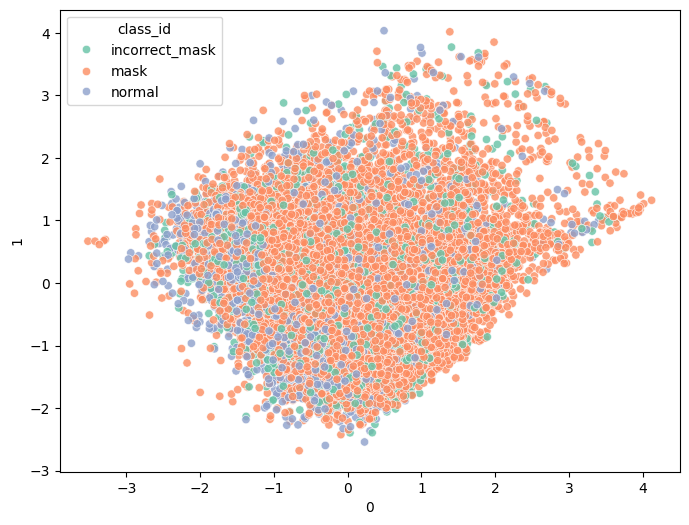

In [162]:
fig, ax = plt.subplots(1,1,figsize=(8, 6))
ax.set_facecolor('white')
sns.scatterplot(
    x='0', y='1',
    hue="class_id",
    data=pca_df,
    legend="full",
    palette=sns.color_palette("Set2", 3),
    alpha=0.8
)
plt.show()

In [159]:
time_start = time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(img_pca)
print('t-SNE done! Time elapsed: {} seconds'.format(time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 18900 samples in 0.001s...
[t-SNE] Computed neighbors for 18900 samples in 0.829s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18900
[t-SNE] Computed conditional probabilities for sample 2000 / 18900
[t-SNE] Computed conditional probabilities for sample 3000 / 18900
[t-SNE] Computed conditional probabilities for sample 4000 / 18900
[t-SNE] Computed conditional probabilities for sample 5000 / 18900
[t-SNE] Computed conditional probabilities for sample 6000 / 18900
[t-SNE] Computed conditional probabilities for sample 7000 / 18900
[t-SNE] Computed conditional probabilities for sample 8000 / 18900
[t-SNE] Computed conditional probabilities for sample 9000 / 18900
[t-SNE] Computed conditional probabilities for sample 10000 / 18900
[t-SNE] Computed conditional probabilities for sample 11000 / 18900
[t-SNE] Computed conditional probabilities for sample 12000 / 18900
[t-SNE] Computed conditional probabilities for sa

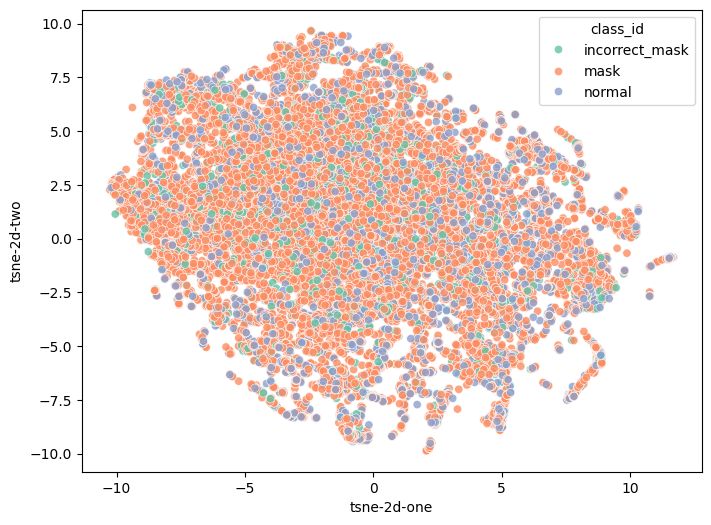

In [160]:
pca_df['tsne-2d-one'] = tsne_results[:,0]
pca_df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(8,6))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="class_id",
    palette=sns.color_palette("Set2", 3),
    data=pca_df,
    legend="full",
    alpha=0.8
)
plt.show()

#### 6. feature 로 t-SNE 분석 

In [8]:
import torch
from torchvision.models import resnet50

from dataset import MaskBaseDataset, CustomAugmentation
from torch.utils.data import DataLoader

In [9]:
dataset = MaskBaseDataset('../train/images/')

In [10]:
dataset.set_transform(CustomAugmentation(resize=(128, 96), mean=dataset.mean, std=dataset.std))

In [11]:
# 특징 벡터 추출을 위한 함수 정의
def extract_features(model, dataloader):
    features = []
    labels = []
    
    model.eval()

    with torch.no_grad():
        for images, targets in tqdm(dataloader):
            outputs = model(images)
            features.append(outputs.squeeze())
            labels.extend(targets.numpy())

    features = torch.cat(features).numpy()
    return features, labels

  0%|          | 0/296 [00:00<?, ?it/s]

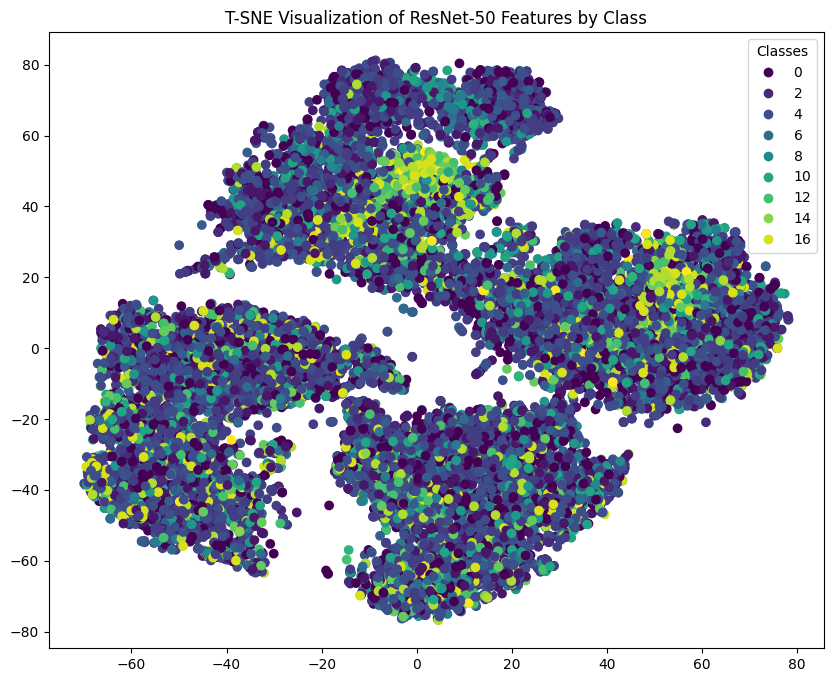

In [173]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# ResNet-50 모델 불러오기
model = resnet50(pretrained=True)

# 마지막 fully connected layer 이전의 모델로 변경
model = torch.nn.Sequential(*(list(model.children())[:-1]))
model.eval()

# 특징 벡터 추출
features, labels = extract_features(model, dataloader)

# T-SNE 적용
tsne = TSNE(n_components=2, random_state=42)
embedded_features = tsne.fit_transform(features)

# 시각화
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedded_features[:, 0], embedded_features[:, 1], c=labels, cmap='viridis')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("T-SNE Visualization of ResNet-50 Features by Class")
plt.show()


In [185]:
len(embedded_features), len(labels)

(18900, 18900)

In [186]:
m_labels = [(label // 6) % 3 for label in labels]
g_labels = [(label // 3) % 2 for label in labels]
a_labels = [label % 3 for label in labels]

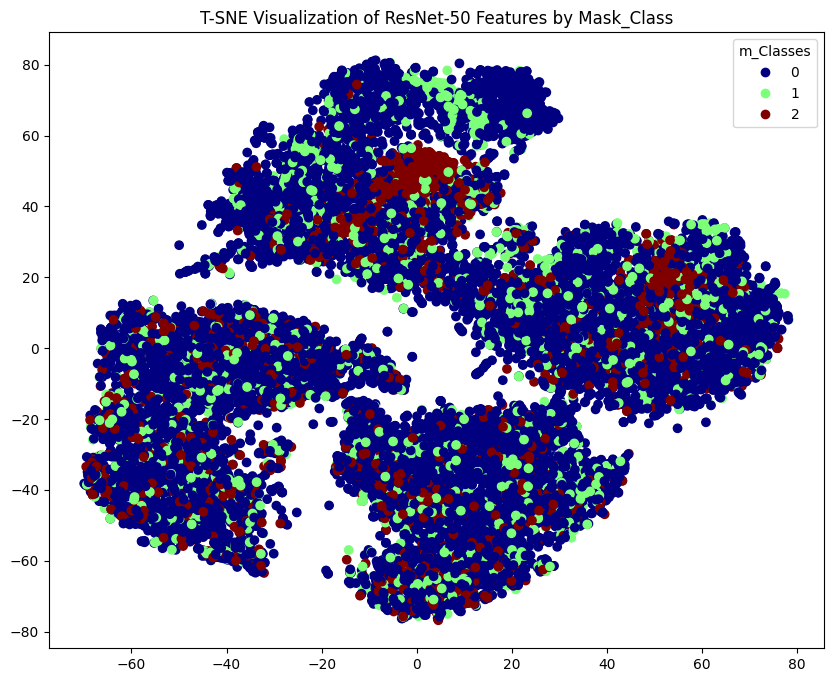

In [187]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedded_features[:, 0], embedded_features[:, 1], c=m_labels, cmap='jet')
plt.legend(*scatter.legend_elements(), title="m_Classes")
plt.title("T-SNE Visualization of ResNet-50 Features by Mask_Class")
plt.show()

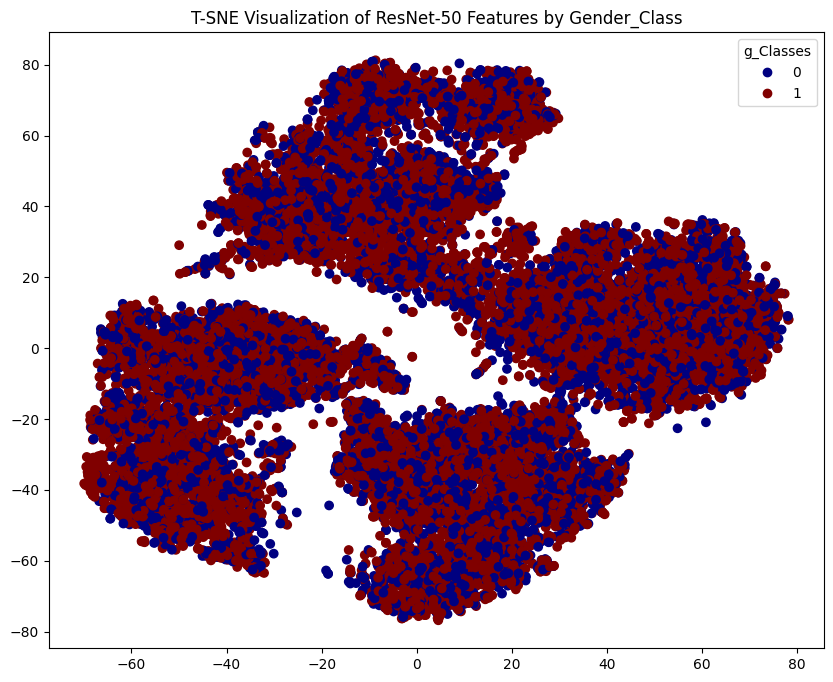

In [188]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedded_features[:, 0], embedded_features[:, 1], c=g_labels, cmap='jet')
plt.legend(*scatter.legend_elements(), title="g_Classes")
plt.title("T-SNE Visualization of ResNet-50 Features by Gender_Class")
plt.show()

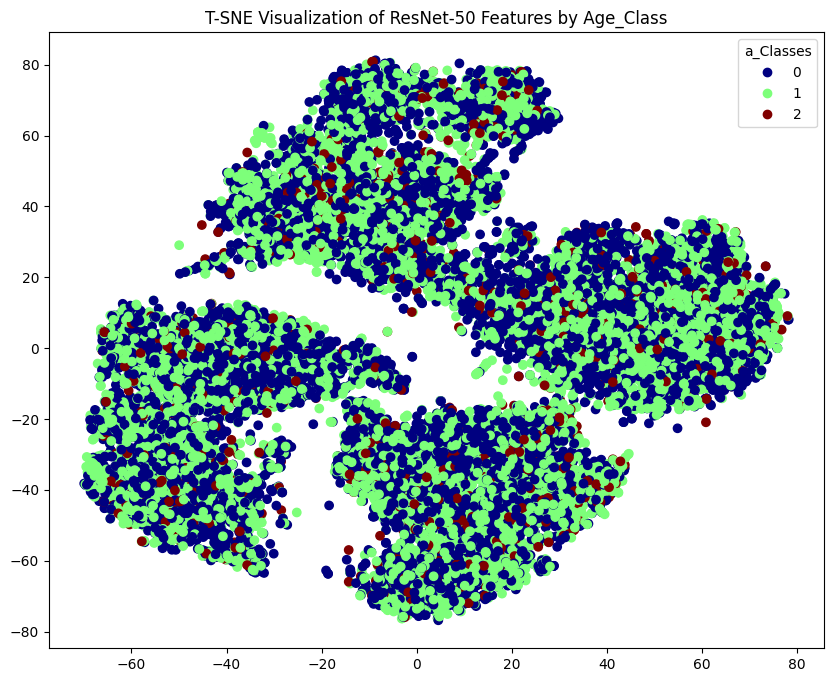

In [189]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedded_features[:, 0], embedded_features[:, 1], c=a_labels, cmap='jet')
plt.legend(*scatter.legend_elements(), title="a_Classes")
plt.title("T-SNE Visualization of ResNet-50 Features by Age_Class")
plt.show()

#### 7. 학습시킨 모델로 feature t-SNE 분석

In [23]:
import torch
from model import MultiLabelModel, MFEfficientResNet

In [27]:
model = MFEfficientResNet(18)
model.load_state_dict(torch.load("/data/ephemeral/home/level1-imageclassification-cv-12/model/202312191300/bkh_202312191300/best.pth")['model_state_dict'])

<All keys matched successfully>

In [14]:
model = model.features

In [17]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

features, labels = extract_features(model, dataloader)

tsne = TSNE(n_components=2, random_state=42)
embedded_features = tsne.fit_transform(features)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedded_features[:, 0], embedded_features[:, 1], c=labels, cmap='viridis')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("T-SNE Visualization of EfficientNet Features by Class")
plt.show()


  0%|          | 0/296 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
m_labels = [(label // 6) % 3 for label in labels]
g_labels = [(label // 3) % 2 for label in labels]
a_labels = [label % 3 for label in labels]

In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedded_features[:, 0], embedded_features[:, 1], c=m_labels, cmap='jet')
plt.legend(*scatter.legend_elements(), title="m_Classes")
plt.title("T-SNE Visualization of EfficientNet Features by Mask_Class")
plt.show()

In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedded_features[:, 0], embedded_features[:, 1], c=g_labels, cmap='jet')
plt.legend(*scatter.legend_elements(), title="g_Classes")
plt.title("T-SNE Visualization of EfficientNet Features by Gender_Class")
plt.show()

In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedded_features[:, 0], embedded_features[:, 1], c=a_labels, cmap='jet')
plt.legend(*scatter.legend_elements(), title="a_Classes")
plt.title("T-SNE Visualization of EfficientNet Features by Age_Class")
plt.show()

In [56]:
model_path = os.path.join('/data/ephemeral/home/level1-imageclassification-cv-12/model/202312181427/bkh_2023121814272', "best.pth")
checkpoint = torch.load(model_path, map_location=device)
checkpoint.keys()

odict_keys(['backbone1.0.weight', 'backbone1.1.weight', 'backbone1.1.bias', 'backbone1.1.running_mean', 'backbone1.1.running_var', 'backbone1.1.num_batches_tracked', 'backbone1.4.0.conv1.weight', 'backbone1.4.0.bn1.weight', 'backbone1.4.0.bn1.bias', 'backbone1.4.0.bn1.running_mean', 'backbone1.4.0.bn1.running_var', 'backbone1.4.0.bn1.num_batches_tracked', 'backbone1.4.0.conv2.weight', 'backbone1.4.0.bn2.weight', 'backbone1.4.0.bn2.bias', 'backbone1.4.0.bn2.running_mean', 'backbone1.4.0.bn2.running_var', 'backbone1.4.0.bn2.num_batches_tracked', 'backbone1.4.0.conv3.weight', 'backbone1.4.0.bn3.weight', 'backbone1.4.0.bn3.bias', 'backbone1.4.0.bn3.running_mean', 'backbone1.4.0.bn3.running_var', 'backbone1.4.0.bn3.num_batches_tracked', 'backbone1.4.0.downsample.0.weight', 'backbone1.4.0.downsample.1.weight', 'backbone1.4.0.downsample.1.bias', 'backbone1.4.0.downsample.1.running_mean', 'backbone1.4.0.downsample.1.running_var', 'backbone1.4.0.downsample.1.num_batches_tracked', 'backbone1.4.1

In [1]:
import timm

In [11]:
model = timm.create_model('tresnet_m_miil_in21k', pretrained=True)
list(model.children())[-1]

/opt/conda/envs/cv12_bkh/lib/python3.8/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tresnet_m_miil_in21k to current tresnet_m.miil_in21k.
  model = create_fn(


ClassifierHead(
  (global_pool): SelectAdaptivePool2d(pool_type=fast, flatten=Identity())
  (drop): Dropout(p=0.0, inplace=False)
  (fc): Linear(in_features=2048, out_features=11221, bias=True)
  (flatten): Identity()
)

In [29]:
mixer1 = timm.create_model('mixer_b16_224_miil_in21k', pretrained=True)
print(list(mixer1.children()))

/opt/conda/envs/cv12_bkh/lib/python3.8/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name mixer_b16_224_miil_in21k to current mixer_b16_224.miil_in21k.
  model = create_fn(


[PatchEmbed(
  (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (norm): Identity()
), Sequential(
  (0): MixerBlock(
    (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (mlp_tokens): Mlp(
      (fc1): Linear(in_features=196, out_features=384, bias=True)
      (act): GELU(approximate=none)
      (drop1): Dropout(p=0.0, inplace=False)
      (norm): Identity()
      (fc2): Linear(in_features=384, out_features=196, bias=True)
      (drop2): Dropout(p=0.0, inplace=False)
    )
    (drop_path): Identity()
    (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (mlp_channels): Mlp(
      (fc1): Linear(in_features=768, out_features=3072, bias=True)
      (act): GELU(approximate=none)
      (drop1): Dropout(p=0.0, inplace=False)
      (norm): Identity()
      (fc2): Linear(in_features=3072, out_features=768, bias=True)
      (drop2): Dropout(p=0.0, inplace=False)
    )
  )
  (1): MixerBlock(
    (norm1): LayerNorm((768,), eps=1e-06, elementwise_a

In [2]:
model = timm.create_model('efficientvit_b3.r224_in1k', pretrained=True)
print(model)

model.safetensors:   0%|          | 0.00/195M [00:00<?, ?B/s]

EfficientVit(
  (stem): Stem(
    (in_conv): ConvNormAct(
      (dropout): Dropout(p=0.0, inplace=False)
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): Hardswish()
    )
    (res0): ResidualBlock(
      (pre_norm): Identity()
      (main): DSConv(
        (depth_conv): ConvNormAct(
          (dropout): Dropout(p=0.0, inplace=False)
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): Hardswish()
        )
        (point_conv): ConvNormAct(
          (dropout): Dropout(p=0.0, inplace=False)
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [61]:
torch.nn.Sequential(model.head.global_pool)

Sequential(
  (0): SelectAdaptivePool2d(pool_type=avg, flatten=Flatten(start_dim=1, end_dim=-1))
)

In [60]:
model.head.in_conv

ConvNormAct(
  (dropout): Dropout(p=0.0, inplace=False)
  (conv): Conv2d(512, 2304, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm): BatchNorm2d(2304, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): Hardswish()
)

In [54]:
import torch
torch.nn.Sequential(
            model.head.in_conv,
            model.head.global_pool,
            torch.nn.Linear(2304, 2560, bias=False),
            torch.nn.LayerNorm((2560,),1e-05,elementwise_affine=True),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Dropout(p=0.0, inplace=False),
            torch.nn.Linear(2560, 2, bias=True)
        )

Sequential(
  (0): ConvNormAct(
    (dropout): Dropout(p=0.0, inplace=False)
    (conv): Conv2d(512, 2304, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (norm): BatchNorm2d(2304, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): Hardswish()
  )
  (1): SelectAdaptivePool2d(pool_type=avg, flatten=Flatten(start_dim=1, end_dim=-1))
  (2): Linear(in_features=2304, out_features=2560, bias=False)
  (3): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
  (4): LeakyReLU(negative_slope=0.1)
  (5): Dropout(p=0.0, inplace=False)
  (6): Linear(in_features=2560, out_features=2, bias=True)
)

In [33]:
list(model.children())[-1:]

[ClassifierHead(
   (in_conv): ConvNormAct(
     (dropout): Dropout(p=0.0, inplace=False)
     (conv): Conv2d(512, 2304, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (norm): BatchNorm2d(2304, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (act): Hardswish()
   )
   (global_pool): SelectAdaptivePool2d(pool_type=avg, flatten=Flatten(start_dim=1, end_dim=-1))
   (classifier): Sequential(
     (0): Linear(in_features=2304, out_features=2560, bias=False)
     (1): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
     (2): Hardswish()
     (3): Dropout(p=0.0, inplace=False)
     (4): Linear(in_features=2560, out_features=1000, bias=True)
   )
 )]

In [6]:
model2 = timm.create_model(
    'efficientvit_b3.r224_in1k',
    pretrained=True,
    features_only=True,
)
print(model2)

FeatureListNet(
  (stem_in_conv): ConvNormAct(
    (dropout): Dropout(p=0.0, inplace=False)
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): Hardswish()
  )
  (stem_res0): ResidualBlock(
    (pre_norm): Identity()
    (main): DSConv(
      (depth_conv): ConvNormAct(
        (dropout): Dropout(p=0.0, inplace=False)
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): Hardswish()
      )
      (point_conv): ConvNormAct(
        (dropout): Dropout(p=0.0, inplace=False)
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): Identity()
      )
    )
    (shor

In [7]:
model3 = timm.create_model(
    'efficientvit_l3.r224_in1k',
    pretrained=True,
    features_only=True,
)
print(model3)

model.safetensors:   0%|          | 0.00/984M [00:00<?, ?B/s]

FeatureListNet(
  (stem_in_conv): ConvNormAct(
    (dropout): Dropout(p=0.0, inplace=False)
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (norm): BatchNorm2d(64, eps=1e-07, momentum=0.1, affine=True, track_running_stats=True)
    (act): GELUTanh()
  )
  (stem_res0): ResidualBlock(
    (pre_norm): Identity()
    (main): ConvBlock(
      (conv1): ConvNormAct(
        (dropout): Dropout(p=0.0, inplace=False)
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (norm): BatchNorm2d(64, eps=1e-07, momentum=0.1, affine=True, track_running_stats=True)
        (act): GELUTanh()
      )
      (conv2): ConvNormAct(
        (dropout): Dropout(p=0.0, inplace=False)
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (norm): BatchNorm2d(64, eps=1e-07, momentum=0.1, affine=True, track_running_stats=True)
        (act): Identity()
      )
    )
    (shortcut

In [24]:
list(model3.children())[-1:]

[EfficientVitLargeStage(
   (blocks): Sequential(
     (0): ResidualBlock(
       (pre_norm): Identity()
       (main): MBConv(
         (inverted_conv): ConvNormAct(
           (dropout): Dropout(p=0.0, inplace=False)
           (conv): Conv2d(512, 12288, kernel_size=(1, 1), stride=(1, 1))
           (norm): Identity()
           (act): GELUTanh()
         )
         (depth_conv): ConvNormAct(
           (dropout): Dropout(p=0.0, inplace=False)
           (conv): Conv2d(12288, 12288, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=12288)
           (norm): Identity()
           (act): GELUTanh()
         )
         (point_conv): ConvNormAct(
           (dropout): Dropout(p=0.0, inplace=False)
           (conv): Conv2d(12288, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
           (norm): BatchNorm2d(1024, eps=1e-07, momentum=0.1, affine=True, track_running_stats=True)
           (act): Identity()
         )
       )
     )
     (1): EfficientVitBlock(
       (context